Midterm Project

Bruce Nie

In [3]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


https://www.kaggle.com/datasets/justinas/nba-players-data
This dataset has various statistics for every player that has played in the NBA from the 1996 season to the 2022 season. The stats I will be focusing on in this project are the true shooting percentage, points per game, usage rate, and age.
Originally, I had wanted to do my midterm project about how shot selection has changed in the NBA throughout the season, as by watching NBA games it seems like teams are shooting more and more 3-pointers and I wanted to see if the data backed that up. However, the original link I researched did not have an actual CSV to download this data, so I researched for more datasets and came around this very extensive dataset and decided to investigate various different, but related, questions about the correlation of True Shooting Percentage with age, draft year, and scoring.

In [5]:
player_data = Table.read_table("all_seasons_cleaned.csv")
player_data.show(5)

Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,season_start,height_in
0,Randy Livingston,HOU,22,193.04,94.8007,Louisiana State,USA,1996,2,42,64,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,1996,76
1,Gaylon Nickerson,WAS,28,190.5,86.1825,Northwestern Oklahoma,USA,1994,2,34,4,3.8,1.3,0.3,8.9,0.03,0.111,0.174,0.497,0.043,1996-97,1996,75
2,George Lynch,VAN,26,203.2,103.419,North Carolina,USA,1993,1,12,41,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,1996,80
3,George McCloud,LAL,30,203.2,102.058,Florida State,USA,1989,1,7,64,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,1996,80
4,George Zidek,DEN,23,213.36,119.748,UCLA,USA,1995,1,22,52,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.5,0.064,1996-97,1996,84


Question 1: Which players had the highest True Shooting Percentage (ts_pct) in a given season?

In this question, I want to find out which players were the most efficient scorers in each season based on their True Shooting Percentage. This stat accounts for field goals, 3-point shots, and free throws to give a more complete picture of a player's scoring efficiency.

In [7]:
top_ts_players = []
top_ts_values = []
season_years = []
for season in np.unique(player_data.column("season_start")):
    season_table = player_data.where("season_start", season)
    sorted_table = season_table.sort("ts_pct", descending=True)
    top_player = sorted_table.column("player_name").item(0)
    top_ts = sorted_table.column("ts_pct").item(0)
    season_years.append(season)
    top_ts_players.append(top_player)
    top_ts_values.append(top_ts*100)
top_ts_table = Table().with_columns(
    "Season", season_years,
    "Top Player", top_ts_players,
    "TS%", top_ts_values
)
top_ts_table.show()

Season,Top Player,TS%
1996,Steve Scheffler,79.9
1997,Tom Chambers,104.2
1998,Tyson Wheeler,106.4
1999,Ira Bowman,86.8
2000,Jason Hart,100
2001,Ratko Varda,72.7
2002,Chris Crawford,72.6
2003,Kaniel Dickens,90.2
2004,Donnell Harvey,106.4
2005,Randy Holcomb,100


1.2: 
Even as a fan of the NBA, I don't recognize many of these names. That's because many of these players might have barely played and made the few shots they attempted, heavily skewing their True Shooting Percentage. In this next cell, let's put a criteria that the player has to have played in at least 30 games and averaged 10 points per game.


In [9]:
top_ts_players = []
top_ts_values = []
season_years = []

for season in np.unique(player_data.column("season_start")):
    season_table = player_data.where("season_start", season)
    filtered = season_table.where("gp", are.above_or_equal_to(30)).where("pts", are.above_or_equal_to(10))

    sorted_filtered = filtered.sort("ts_pct", descending=True)
    top_player = sorted_filtered.column("player_name").item(0)
    top_ts = sorted_filtered.column("ts_pct").item(0)

    season_years.append(season)
    top_ts_players.append(top_player)
    top_ts_values.append(top_ts*100)

filtered_top_ts_table = Table().with_columns(
    "Season", season_years,
    "Top Player", top_ts_players,
    "TS%", top_ts_values
)

filtered_top_ts_table.show()

Season,Top Player,TS%
1996,Mario Elie,66.2
1997,John Stockton,62.8
1998,Chris Mullin,61.6
1999,Dikembe Mutombo,62.1
2000,John Stockton,61
2001,Brent Barry,65.2
2002,Eddy Curry,60.7
2003,Brent Barry,66.8
2004,Damon Jones,62.5
2005,Steve Nash,63.2


Now this is a list filled with more familiar names. To get here, we used various table methods such as sort() and where(). The sort method reorders the rows of a table based on the values in a specified column, in ascending order by default. We were able to use set descending = True as an argument to make the sort method reorder the values descending instead. The where method is used to filter rows in a table based on a given condition. For example, in 1.2 we needed to filter players that have played at least 30 games and averaged more than 10 points per game, so we used the where method to filter our table to only include rows where the value in the Games Played (gp) column was 30 or higher, and the value in the Points (pts) column was 10 or higher.

Question 2: Is there a correlation between points per game and True Shooting Percentage?
2.1
Do the highest scoring players tend to be efficient? Let's find the top 3 scorers of each season (min. 30 games played) and make a table with the season, name, points per game (pts), and True Shooting (TS%).

In [12]:
top_names = []
top_seasons = []
top_pts = []
top_ts_pct = []

for season in np.unique(player_data.column("season_start")):
    season_data = player_data.where("season_start", season).where("gp", are.above_or_equal_to(30))
    top_scorers = season_data.sort("pts", descending=True).take(np.arange(3))
    for i in np.arange(3):
        top_names.append(top_scorers.column("player_name").item(i))
        top_seasons.append(season)
        top_pts.append(top_scorers.column("pts").item(i))
        top_ts_pct.append(top_scorers.column("ts_pct").item(i) * 100) 

top_3_scorers_table = Table().with_columns(
    "Season", top_seasons,
    "Player", top_names,
    "PPG", top_pts,
    "TS%", top_ts_pct
)

top_3_scorers_table.show()

Season,Player,PPG,TS%
1996,Michael Jordan,29.6,56.7
1996,Karl Malone,27.4,60
1996,Glen Rice,26.8,60.5
1997,Michael Jordan,28.7,53.3
1997,Shaquille O'Neal,28.3,58.7
1997,Karl Malone,27,59.7
1998,Allen Iverson,26.8,50.8
1998,Shaquille O'Neal,26.3,58.4
1998,Karl Malone,23.8,57.7
1999,Shaquille O'Neal,29.7,57.8


2.2 Average TS% of each season:
While this table is a great start, we have nothing to compare these stats to. So for our next step, let's find the average TS% of each season, using the same criteria of a minimum of 30 games played and a PPG average of 10.

In [14]:
qualified_players = player_data.where("gp", are.above_or_equal_to(30))
ts_data = qualified_players.select("season_start", "ts_pct")
avg_ts_by_season = ts_data.group("season_start", np.mean)
avg_ts_pct = avg_ts_by_season.column("ts_pct mean") * 100
avg_ts_table = avg_ts_by_season.select("season_start").with_column("Avg TS%", avg_ts_pct)

avg_ts_table.show()

season_start,Avg TS%
1996,52.6325
1997,51.3963
1998,50.749
1999,51.1939
2000,50.7026
2001,50.959
2002,50.7582
2003,50.4954
2004,51.8346
2005,52.186


We just used two more table methods, select() and group(). The select method is used to choose specific columns from a table. When you use select(), you’re basically filtering the table to include only the columns you want to work with. The group method is used to group rows in a table based on a certain column. When you apply group(), you're aggregating the data by the specified column, and you can then perform operations such as sum or mean more easily. 

Now let's compare this data by subtracting the TS% of the top scorers of each year to the average TS% of that year. Let's include these values into a new column on our table, TS% Difference.

In [17]:
avg_ts_for_each_player = []

for i in np.arange(top_3_scorers_table.num_rows):
    player_season = top_3_scorers_table.column("Season").item(i)
    
    matching_avg = avg_ts_table.where("season_start", player_season).column("Avg TS%").item(0)
    
    avg_ts_for_each_player.append(matching_avg)
avg_ts_array = np.array(avg_ts_for_each_player)

ts_pct_diff = top_3_scorers_table.column("TS%") - avg_ts_array

top_3_vs_avg_table = top_3_scorers_table.with_columns(
    "League Avg TS%", avg_ts_array,
    "TS% Difference", ts_pct_diff
)

top_3_vs_avg_table.show()

Season,Player,PPG,TS%,League Avg TS%,TS% Difference
1996,Michael Jordan,29.6,56.7,52.6325,4.06746
1996,Karl Malone,27.4,60,52.6325,7.36746
1996,Glen Rice,26.8,60.5,52.6325,7.86746
1997,Michael Jordan,28.7,53.3,51.3963,1.90375
1997,Shaquille O'Neal,28.3,58.7,51.3963,7.30375
1997,Karl Malone,27,59.7,51.3963,8.30375
1998,Allen Iverson,26.8,50.8,50.749,0.0510274
1998,Shaquille O'Neal,26.3,58.4,50.749,7.65103
1998,Karl Malone,23.8,57.7,50.749,6.95103
1999,Shaquille O'Neal,29.7,57.8,51.1939,6.60607


With a quick glance through our table, we can already see that each of the leading scorers every year had a positive difference in TS%, meaning they were above average compared to their peers. To see exactly how much better their TS% usually is, let's find the average difference of these top scorers.

In [19]:
ts_diff = top_3_vs_avg_table.column("TS% Difference")

total_diff = np.sum(ts_diff)

avg_diff = np.mean(ts_diff)

print("Total TS% difference:", round(total_diff, 2))
print("Average TS% difference per player:", round(avg_diff, 2))

Total TS% difference: 410.19
Average TS% difference per player: 5.06


We can better visualize this data with a graph. In this situation, we are comparing two trends over time, so the best way must be the line graph.

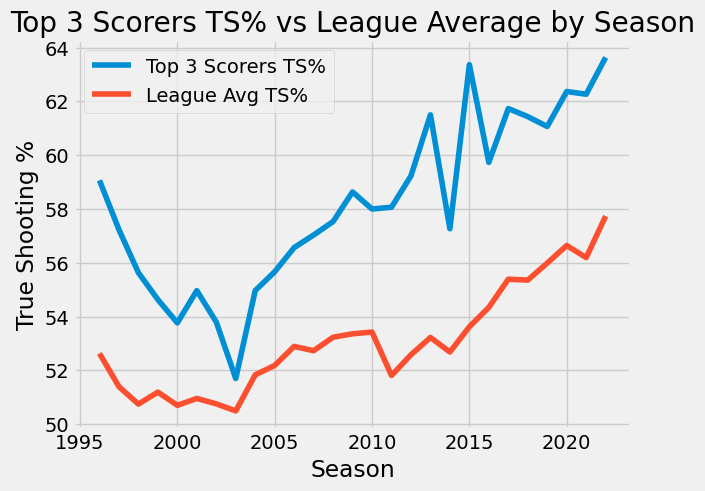

In [21]:
avg_top_ts_by_season = top_3_vs_avg_table.select("Season", "TS%").group("Season", np.mean)

league_avg_ts = avg_ts_table.select("season_start", "Avg TS%").relabeled("season_start", "Season")

ts_compare_table = avg_top_ts_by_season.join("Season", league_avg_ts)

ts_compare_table = ts_compare_table.relabeled("TS% mean", "Top 3 Scorers TS%").relabeled("Avg TS%", "League Avg TS%")

seasons = ts_compare_table.column("Season")
top_ts = ts_compare_table.column("Top 3 Scorers TS%")
avg_ts = ts_compare_table.column("League Avg TS%")


plots.plot(seasons, top_ts, label="Top 3 Scorers TS%")
plots.plot(seasons, avg_ts, label="League Avg TS%")

plots.xlabel("Season")
plots.ylabel("True Shooting %")
plots.title("Top 3 Scorers TS% vs League Average by Season")
plots.legend()
plots.grid(True)
plots.show()

Looking at this graph, we can clearly see the average TS% of the top 3 scorers was often a great deal higher than the league average TS% for that same season. We can conclude that there seems to be a correlation between top scorers and True Shooting Percentage, as the top scorers tend to be more efficient than average.

Question 3: Do younger players tend to shoot more efficiently? As we can see in the line graph we made earlier, there is a noticable trend up in league average TS% as the years go on. Let's examine how TS% correlates to age and the era the player is playing in.

3.1 First, we’ll analyze whether younger players (based on age) tend to have higher TS% than older players. If age is strongly correlated with shooting efficiency, we might expect to see younger players outperform veterans on a per-season basis.

In [25]:
def age_group(age):
    if age < 25:
        return "18-24"
    elif age < 30:
        return "25–29"
    elif age < 35:
        return "30–34"
    else:
        return "35+"

qualified = player_data.where("gp", are.above_or_equal_to(30)).where("pts", are.above_or_equal_to(10))

age_bins = qualified.apply(age_group, "age")
binned = qualified.with_column("age_group", age_bins)

pivot_table = binned.pivot("season_start", "age_group", values="ts_pct", collect=np.mean)

for label in pivot_table.labels[1:]:
    pct_col = pivot_table.column(label)
    pivot_table = pivot_table.with_column(label, np.round(pct_col * 100, 2))

pivot_table.show()

age_group,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
18-24,53.01,52.24,52.06,52.72,53.52,53.35,53.49,52.6,53.97,55.17,55.74,55.03,55.03,54.06,54.24,54.11,53.91,53.84,53.54,53.85,55.46,55.04,55.97,56.34,56.99,56.01,57.35
25–29,53.92,53.08,51.82,53.16,52.68,52.72,53.47,53.13,54.58,54.37,55.03,55.74,55.91,55.73,55.27,54.42,54.53,55.25,54.6,55.46,56.49,56.73,56.98,57.51,58.24,58.02,59.29
30–34,56.1,53.94,52.1,52.98,52.41,54.03,53.04,52.79,53.07,53.92,54.66,55.28,54.26,54.95,55.62,53.44,54.82,55.71,55.44,54.95,56.84,57.27,57.72,56.68,58.58,57.07,59.39
35+,56.3,55.75,55.28,54.81,55.19,53.73,53.27,53.62,54,53.4,53.65,54,59.45,57.95,56.23,54.47,56.66,56.65,54.67,52.05,53.99,53.24,53.57,58.94,57.86,59.77,59.53


Using the pivot() method, we can easily compare TS% of different age groups through different seasons. The pivot method rearranges a table to show summary values for two variables (like a spreadsheet), using a third variable for the values.

Now, let's calculate how the different age group's stack up to that season's league average TS%.

In [28]:
seasons_list = []
age_group_list = []
group_ts_pct_list = []
league_avg_list = []
ts_diff_list = []
for season in np.unique(player_data.column("season_start")):
    season_data = player_data.where("season_start", season).where("gp", are.above_or_equal_to(30)).where("pts", are.above_or_equal_to(10))
    
    league_avg_ts = np.mean(season_data.column("ts_pct")) * 100
    age_bins = season_data.apply(age_group, "age")
    binned = season_data.with_column("age_group", age_bins)

    grouped = binned.select("age_group", "ts_pct").group("age_group", np.mean)

    for i in np.arange(grouped.num_rows):
        age_bin = grouped.column("age_group").item(i)
        avg_ts = grouped.column("ts_pct mean").item(i) * 100
        ts_diff = avg_ts - league_avg_ts

        seasons_list.append(season)
        age_group_list.append(age_bin)
        group_ts_pct_list.append(avg_ts)
        league_avg_list.append(league_avg_ts)
        ts_diff_list.append(ts_diff)

age_bin_season_table = Table().with_columns(
    "Season", seasons_list,
    "Age Group", age_group_list,
    "Avg TS%", group_ts_pct_list,
    "League Avg TS%", league_avg_list,
    "TS% Difference", ts_diff_list
)

age_bin_season_table.show()

Season,Age Group,Avg TS%,League Avg TS%,TS% Difference
1996,18-24,53.012,54.5533,-1.54133
1996,25–29,53.923,54.5533,-0.630383
1996,30–34,56.0952,54.5533,1.5419
1996,35+,56.3,54.5533,1.74667
1997,18-24,52.2448,53.3594,-1.11457
1997,25–29,53.0828,53.3594,-0.27664
1997,30–34,53.9382,53.3594,0.578837
1997,35+,55.75,53.3594,2.3906
1998,18-24,52.0615,52.4468,-0.385308
1998,25–29,51.82,52.4468,-0.626847


For this question, we used the method apply(). The apply() method is used to apply a function to each value in a specified column and return a new column with the results. 

Now that we have this table, we can easily calculate the average difference in TS% in each age group for each season. 

In [31]:
avg_diff_by_age_group = age_bin_season_table.select("Age Group", "TS% Difference").group("Age Group", np.mean)

avg_diff_by_age_group = avg_diff_by_age_group.relabeled("TS% Difference mean", "Avg TS% Difference")

avg_diff_by_age_group.show()

Age Group,Avg TS% Difference
18-24,-0.547179
25–29,0.174623
30–34,0.133513
35+,0.540104


Based off this table, we can see that it doesn't seem like being younger in age leads to more efficient shooting, rather it even supports the opposite. Next, we can change our approach and group players together by their draft year to see if the era they played in has more of a correlation with the increase in TS%.

In [33]:
qualified = player_data.where("gp", are.above_or_equal_to(30)).where("pts", are.above_or_equal_to(10))
drafted = qualified.where("draft_year", are.not_equal_to("Undrafted"))

draft_years = drafted.apply(int, "draft_year")
drafted = drafted.with_column("draft_year", draft_years)

counts = drafted.group("draft_year")
counts.labels

valid_years = counts.where("count", are.above(15)).column("draft_year")

filtered_drafted = drafted.where("draft_year", are.contained_in(valid_years))
avg_ts_by_draft = filtered_drafted.select("draft_year", "ts_pct").group("draft_year", np.mean)
ts_pct_percent = avg_ts_by_draft.column("ts_pct mean") * 100
plot_ready = avg_ts_by_draft.select("draft_year").with_column("Avg TS%", ts_pct_percent)
plot_ready.show()

draft_year,Avg TS%
1984,55.5077
1985,56.4815
1986,56.4375
1987,56.2654
1988,53.3576
1989,52.15
1990,52.1353
1991,53.8279
1992,54.2527
1993,52.1695


Now we can use the line graph again to visualize this data to find a trend.

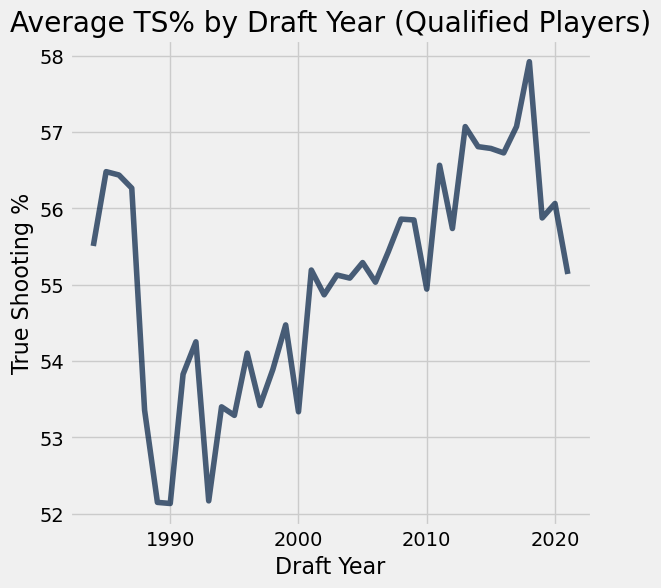

In [35]:
plot_ready.plot("draft_year")

plots.title("Average TS% by Draft Year (Qualified Players)")
plots.xlabel("Draft Year")
plots.ylabel("True Shooting %")
plots.grid(True)
plots.show()


This graph looks pretty confusing. Players drafted in the 1980s seem to have an abnormally high TS%, followed by a sharp decrease into the 1990s. There also seems to be a sharp decrease in TS% for players drafted in the 2020s. However, we have to recognize that our dataset is limited, as it only has stats from the late 1990s to early 2020s, which helps explain these discrepancies. Players drafted in the 1980s still playing in the late 1990s where our dataset starts must've been above average players to have such a long lasting career in the league, skewing their draft class' TS%. Another factor is that their earlier, and usually more inefficient years (as shown in 3.1), were not included since it happened before our dataset. For those drafted where we see the sharp decrease in TS% towards the 2020s, we can once again use our findings from 3.1 to say that younger players usually start off less efficient. A lot of the guys drafted in the 2020s are still early in their careers, and it’s normal for their TS% to be lower at first. As they get more experience and grow into their roles, we can expect their efficiency to go up and eventually match the trend we’ve seen in other draft classes over time.

Now, let's limit our draft years to just those drafted from 1990-2018 to observe a trend in TS% with draft year more clearly.

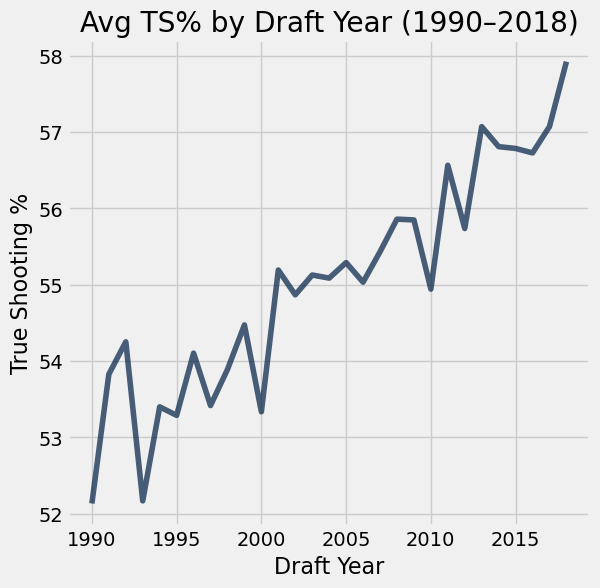

In [38]:
clean_range = plot_ready.where("draft_year", are.between(1990, 2019))

clean_range.plot("draft_year")
plots.title("Avg TS% by Draft Year (1990–2018)")
plots.xlabel("Draft Year")
plots.ylabel("True Shooting %")
plots.grid(True)
plots.show()

Now we can clearly see that players from more recent draft classes tend to have higher TS%, showing us why there has been a trend up in league average TS% as well.

Question 4: Has the distribution of TS% changed throughout eras?

In [41]:
qualified_players = player_data.where("gp", are.above_or_equal_to(30)).where("pts", are.above_or_equal_to(10))

First, let's make a graph of the distribution of TS% in the 2000 season. Using a histogram would fit this situation the best to properly visualize the distribution.

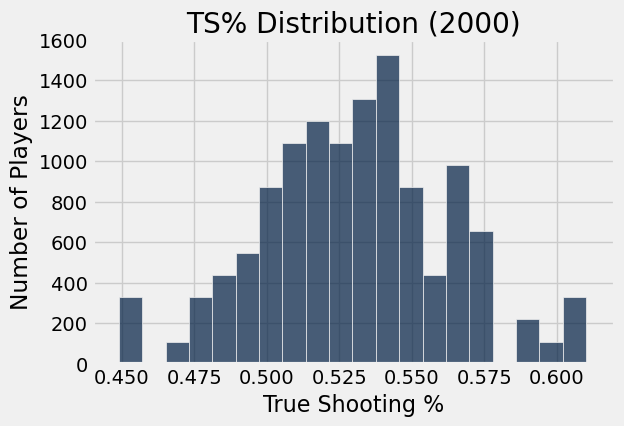

In [43]:
players_2000 = qualified_players.where("season_start", are.equal_to(2000))
players_2000.hist("ts_pct", bins=20)
plots.title("TS% Distribution (2000)")
plots.xlabel("True Shooting %")
plots.ylabel("Number of Players")
plots.grid(True)
plots.xlim(0.44, 0.62) 
plots.ylim(0, 16)

plots.show()


Now, let's make a histogram for the 2020 season.

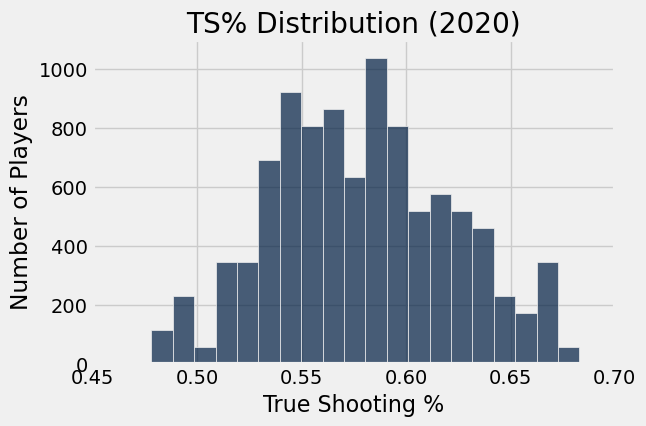

In [45]:
players_2020 = qualified_players.where("season_start", are.equal_to(2020))
players_2020.hist("ts_pct", bins=20)
plots.title("TS% Distribution (2020)")
plots.xlabel("True Shooting %")
plots.ylabel("Number of Players")
plots.grid(True)
plots.xlim(0.45, 0.7) 
plots.ylim(0, 11)
plots.show()

While making these histograms was useful in seeing their distributions on their own, overlapping these two on the same graph might make the comparison easier.

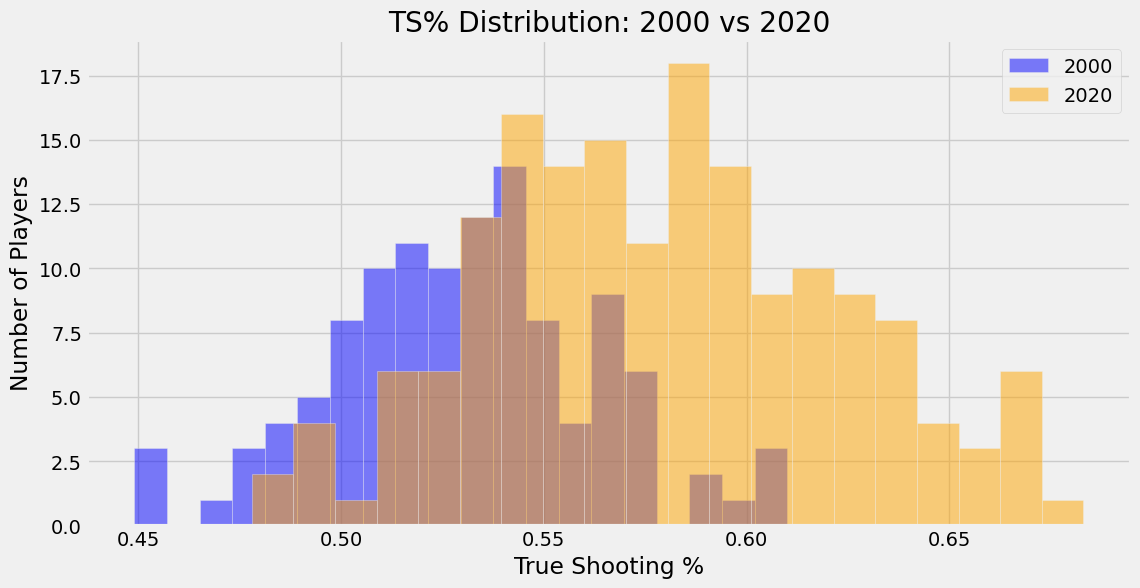

In [47]:
plots.figure(figsize=(12, 6))
plots.hist(players_2000.column("ts_pct"), bins=20, alpha=0.5, label="2000", color='blue')
plots.hist(players_2020.column("ts_pct"), bins=20, alpha=0.5, label="2020", color='orange')
plots.title("TS% Distribution: 2000 vs 2020")
plots.xlabel("True Shooting %")
plots.ylabel("Number of Players")
plots.legend(loc="upper right")
plots.grid(True)

plots.show()

Now with this overlapping histogram, we can better see how not only that the TS% had increased in the 2020 season, but also seems to be more widely distributed compared to the 2000 season.

Question 5: Do taller players or shorter players tend to shoot more efficiently, according to TS%? We can try to answer this question by seeing if there's a correlation between height and TS%.

In [50]:
def height_bin_feet_inches(height):
    if height < 70:
        return "<5'10\""
    elif height <= 74:
        return "5'10\"–6'2\""
    elif height <= 79:
        return "6'3\"–6'7\""
    elif height <= 84:
        return "6'8\"–7'0\""
    else:
        return "7'1\"+"
heights_table = player_data.select("player_name", "player_height", "season_start")

qualified_with_height = qualified_players.join("player_name", heights_table)

heights_in_inches = qualified_with_height.apply(lambda h: h / 2.54, "player_height")

qualified_with_height = qualified_with_height.with_column("height_in", heights_in_inches)
height_groups = qualified_with_height.apply(height_bin_feet_inches, "height_in")
binned = qualified_with_height.with_column("height_group", height_groups)

avg_ts_by_height = binned.select("height_group", "ts_pct").group("height_group", np.mean)
ts_pct_percent = avg_ts_by_height.column("ts_pct mean") * 100
avg_ts_by_height_group = avg_ts_by_height.select("height_group").with_column("Avg TS%", ts_pct_percent)

avg_ts_by_height_group.show()

height_group,Avg TS%
"5'10""–6'2""",54.1168
"6'3""–6'7""",54.9028
"6'8""–7'0""",55.4823
"7'1""+",57.8856
"<5'10""",54.6816


Based off this table, we are able to see that there seems to be a correlation between height and TS%, where the taller the player the more efficiently they shoot usually. This makes sense, as these taller players usually play really close to the basket and therefore have the easiest shots.

Question 6: Does having a higher offensive load (usage percentage) affect your efficiency? Let's invesitgate to see if there is a correlation between the usage rate (usg_pct) of a player and their TS%.

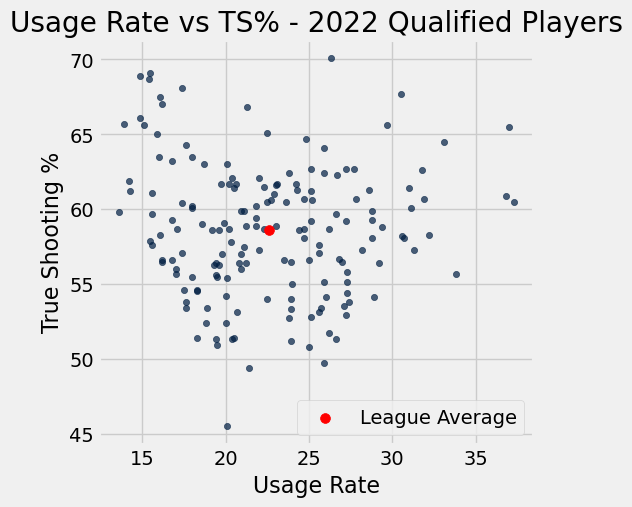

In [53]:
target_season = 2022

season_players = qualified_players.where("season_start", target_season)

scatter_data = season_players.select("usg_pct", "ts_pct").with_columns(
    "usg_pct", season_players.column("usg_pct") * 100,
    "ts_pct", season_players.column("ts_pct") * 100
    ).relabeled("usg_pct", "Usage Rate").relabeled("ts_pct", "True Shooting %")

avg_usg = np.mean(scatter_data.column("Usage Rate"))
avg_ts = np.mean(scatter_data.column("True Shooting %"))

scatter_data.scatter("Usage Rate", "True Shooting %")
plots.scatter(avg_usg, avg_ts, color='red', s=50, label="League Average")
plots.title(f"Usage Rate vs TS% - {target_season} Qualified Players")
plots.grid(True)
plots.legend()
plots.show()


Based off this scatter plot, there seems to be no correlation between usage rate and TS% in the 2022 season. Let's check the other seasons by making a function and changing the season variable to view a different season.

In [55]:
def plot_usg_vs_ts(season):
    season_players = qualified_players.where("season_start", are.equal_to(season))
    
    if season_players.num_rows == 0:
        print(f"No data available for season {season}")
        return

    scatter_data = season_players.select("usg_pct", "ts_pct").with_columns(
        "usg_pct", season_players.column("usg_pct") * 100,
        "ts_pct", season_players.column("ts_pct") * 100
    ).relabeled("usg_pct", "Usage Rate").relabeled("ts_pct", "True Shooting %")
    
    avg_usg = np.mean(scatter_data.column("Usage Rate"))
    avg_ts = np.mean(scatter_data.column("True Shooting %"))

    scatter_data.scatter("Usage Rate", "True Shooting %")
    plots.scatter(avg_usg, avg_ts, color='red', s=50, label="League Average")
    plots.title(f"Usage Rate vs TS% — {season} Qualified Players")
    plots.xlabel("Usage Rate")
    plots.ylabel("True Shooting %")
    plots.grid(True)
    plots.legend()
    plots.show()


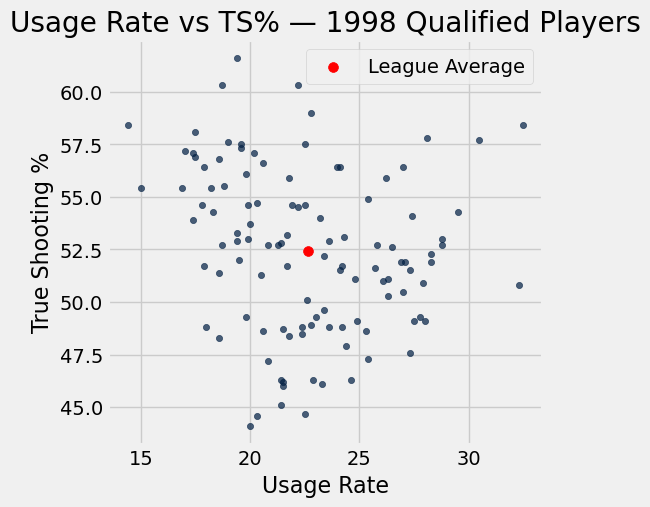

In [56]:
season = 1998
plot_usg_vs_ts(season)

Viewing every season in our dataset, the scatter plot doesn't reveal any correlation between usage rate and TS%, meaning high offensive load does not impact efficiency based off TS%.

Question 7: How does more NBA experience correlate to TS%? As we found out earlier, young NBA players tend to shoot more inefficiently than NBA veterans. So how does seasons played correlate to efficiency?

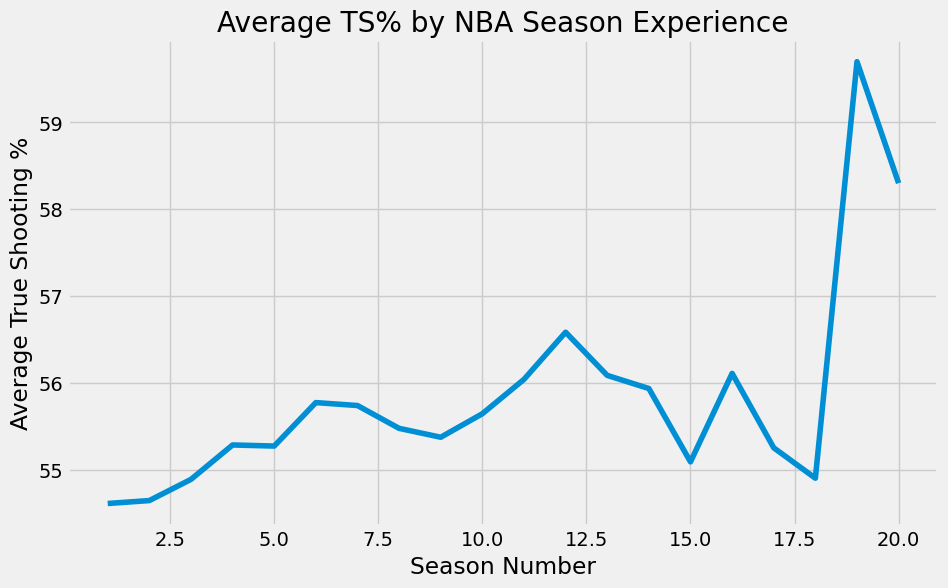

In [59]:
qualified_players = qualified_players.sort("season_start")
qualified_players = qualified_players.sort("player_name")

player_names = qualified_players.column("player_name")
season_ids = []
season_counter = {}
for name in player_names:
    if name not in season_counter:
        season_counter[name] = 1
    else:
        season_counter[name] += 1
    season_ids.append(season_counter[name])

qualified_players = qualified_players.with_column("season_number", season_ids)

season_avg = qualified_players.group("season_number", np.mean).select("season_number", "ts_pct mean")
season_avg = season_avg.with_column("ts_pct (%)", season_avg.column("ts_pct mean") * 100)

# Plot the results
plots.figure(figsize=(10,6))
plots.plot(season_avg.column("season_number"), season_avg.column("ts_pct (%)"))
plots.xlabel("Season Number")
plots.ylabel("Average True Shooting %")
plots.title("Average TS% by NBA Season Experience")
plots.show()

Based off this line graph, we can see that TS% usually peaks around season 10-14 before dropping off. The around season 15, there is a huge jump up in TS%, but I think this is because only a select number of very above average players can have more than 15 seasons played. For example, in 2022, one of the greatest players of all time, LeBron James, was on his 19th season and since there is such a small sample size for players with more than 15 seasons played, we can conclude that the jump in the graph is skewed by players like James who's longevity is a statistical anomaly.

Let's update our graph to end at year 15 to exclude these outliers.

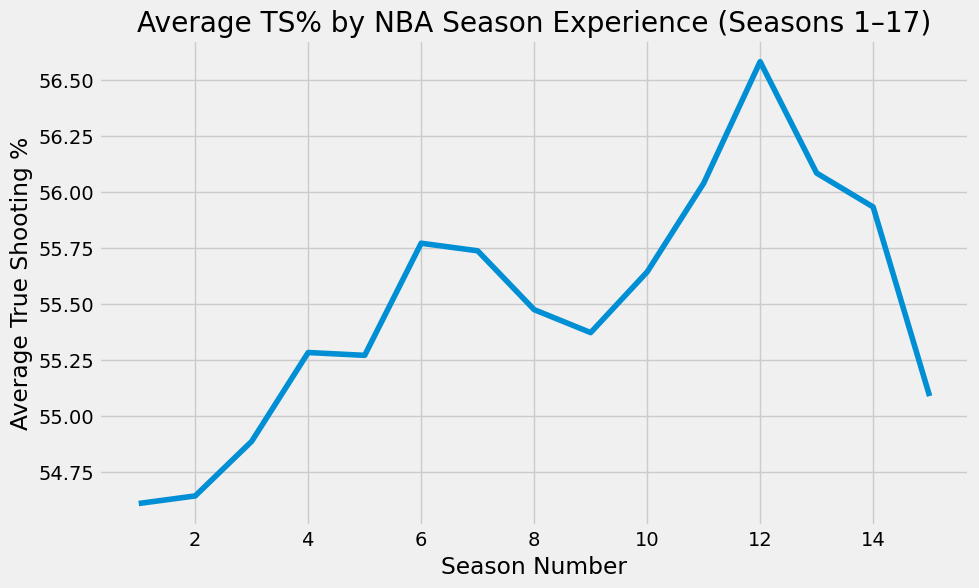

In [62]:
qualified_players = qualified_players.sort("season_start")
qualified_players = qualified_players.sort("player_name")

player_names = qualified_players.column("player_name")
season_ids = []
season_counter = {}
for name in player_names:
    if name not in season_counter:
        season_counter[name] = 1
    else:
        season_counter[name] += 1
    season_ids.append(season_counter[name])
qualified_players = qualified_players.with_column("season_number", season_ids)

filtered = qualified_players.where("season_number", are.below_or_equal_to(15))

season_avg = filtered.group("season_number", np.mean).select("season_number", "ts_pct mean")
season_avg = season_avg.with_column("ts_pct (%)", season_avg.column("ts_pct mean") * 100)

# Plot the results
plots.figure(figsize=(10,6))
plots.plot(season_avg.column("season_number"), season_avg.column("ts_pct (%)"))
plots.xlabel("Season Number")
plots.ylabel("Average True Shooting %")
plots.title("Average TS% by NBA Season Experience (Seasons 1–17)")
plots.show()

Now we can more clearly see the trend, with a player's efficiency peak (according to TS%) starting around year 9, officialy peaking around year 12, and then droppping off until most retire by season 15.

Conclusion: Wrapping up my project, it's clear that player efficiency (TS%) is influenced by a lot of different factors such as height, age, career stage, and era played in. Younger players and high-usage stars don’t always shoot the most efficiently, and efficiency tends to peak around a player’s mid-to-late years. Over time, league-wide TS% has gone up, showing how the game has shifted toward "smarter shots," statistically (more 3-pointers and layups). Overall, this project gave me a deeper look what makes a player truly efficient and the factors that influence their efficiency.